## Document Clustering

In [2]:
# reading the data
read.data <- function(file.name='./assessments_datasets/Task3A.txt', sample.size=1000, seed=100, pre.proc=TRUE, spr.ratio= 0.90) {
  # INPUTS:
  ## file.name: name of the input .txt file
  ## sample.size: if == 0  reads all docs, otherwise only reads a subset of the corpus
  ## seed: random seed for sampling (read above)
  ## pre.proc: if TRUE performs the preprocessing (recommended)
  ## spr.ratio: is used to reduce the sparcity of data by removing very infrequent words
  # OUTPUTS:
  ## docs: the unlabled corpus (each row is a document)
  ## word.doc.mat: the count matrix (each rows and columns corresponds to words and documents, respectively)
  ## label: the real cluster labels (will be used in visualization/validation and not for clustering)
  
  # Read the data
  text <- readLines(file.name)
  # select a subset of data if sample.size > 0
  if (sample.size>0){
    set.seed(seed)
    text <- text[sample(length(text), sample.size)]
  }
  ## the terms before the first '\t' are the lables (the newsgroup names) and all the remaining text after '\t' are the actual documents
  docs <- strsplit(text, '\t')
  # store the labels for evaluation
  labels <-  unlist(lapply(docs, function(x) x[1]))
  # store the unlabeled texts    
  docs <- data.frame(doc_id = 1:length(docs), text = unlist(lapply(docs, function(x) x[2])))
  
                                                                   
  #Cleaning data                                                                 
  library(tm)
  # create a corpus
  docs <- DataframeSource(docs)
  corp <- Corpus(docs)
  
  # Preprocessing:
  if (pre.proc){
    corp <- tm_map(corp, removeWords, stopwords("english")) # remove stop words (the most common word in a language that can be find in any document)
    corp <- tm_map(corp, removePunctuation) # remove pnctuation
    corp <- tm_map(corp, stemDocument) # perform stemming (reducing inflected and derived words to their root form)
    corp <- tm_map(corp, removeNumbers) # remove all numbers
    corp <- tm_map(corp, stripWhitespace) # remove redundant spaces 
  }  
  # Create a matrix which its rows are the documents and colomns are the words. 
  dtm <- DocumentTermMatrix(corp)
  ## reduce the sparcity of out dtm
  dtm <- removeSparseTerms(dtm, spr.ratio)
  ## convert dtm to a matrix
  word.doc.mat <- t(as.matrix(dtm))
  
  # Return the result
  return (list("docs" = docs, "word.doc.mat"= word.doc.mat, "labels" = labels))
}


In [3]:
logSum <- function(v) {
   m = max(v)
   return ( m + log(sum(exp(v-m))))
}

In [4]:
initial.param <- function(vocab_size, K=4, seed=123456){
  rho <- matrix(1/K,nrow = K, ncol=1)                    # assume all clusters have the same size (we will update this later on)
  mu <- matrix(runif(K*vocab_size),nrow = K, ncol = vocab_size)    # initiate Mu 
  mu <- prop.table(mu, margin = 1)               # normalization to ensure that sum of each row is 1
  return (list("rho" = rho, "mu"= mu))
}


In [5]:
eps=1e-10 #used for normalisation

In [6]:
E.step<- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]

  # E step:    
  for (n in 1:N){
    for (k in 1:K){
      ## calculate the posterior based on the estimated mu and rho in the "log space"
      gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
    }
    # normalisation to sum to 1 in the log space
    logZ = logSum(gamma[n,])
    gamma[n,] = gamma[n,] - logZ
  }
  
  # converting back from the log space 
  gamma <- exp(gamma)
  return (gamma)
}

In [7]:
M.step<- function(gamma, model, counts){
    # Model Parameter Setting
      # Model Parameter Setting
    N <- dim(counts)[2]   # number of documents
    W <- dim(counts)[1]   # number of words i.e. vocabulary size
    K <- dim(model$mu)[1] # number of clusters
    for (k in 1:K){
        ## recalculate the estimations:
        model$rho[k] <-sum(gamma[,k])/N     # the relative cluster size
        totalsum=0
        for (g in 1:W){
            totalsum<-totalsum+sum(gamma[,k] * counts[g,])
        }
        for (g in 1:W){
            a<-sum(gamma[,k] * counts[g,])/totalsum
            model$mu[k,g]<-a # new means (cluster cenroids)     
        }
        model$mu[k,]<-(model$mu[k,]+eps)/(sum(model$mu[k,])+ncol(model$mu)*eps)
    }
 return(model)
}

In [8]:
EM.hard <- function(counts, K=4, max.epoch=10, seed=123456){
  #INPUTS:
  ## counts: word count matrix
  ## K: the number of clusters
  #OUTPUTS:
  ## model: a list of model parameters
  
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  W <- dim(counts)[1] # number of unique words (in all documents)
  
  # Initialization
  model <- initial.param(W, K=K, seed=seed)
  gamma <- matrix(0, nrow = N, ncol = K)

  print(train_obj(model,counts))
  # Build the model
 
  for(epoch in 1:max.epoch){
    
    # E Step
    gamma <- E.step(gamma, model, counts)

    #change gamma
    max.prob <- gamma==apply(gamma, 1, max)
    gamma[max.prob] <- 0.9997 
    gamma[!max.prob] <- 0.0001
      
    # M Step
    model <- M.step(gamma, model, counts)
   
    print(train_obj(model,counts)) 
  }
  # Return Model
  return(list("model"=model,"gamma"=gamma))
}

In [9]:
train_obj <- function(model, counts) { 
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]
   
  nloglike = 0
  for (n in 1:N){
    lprob <- matrix(0,ncol = 1, nrow=K)
    for (k in 1:K){
      lprob[k,1] = sum(counts[,n] * log(model$mu[k,])) 
    }
    nloglike <- nloglike - logSum(lprob + log(model$rho))
  }
  
  return (nloglike)
}


In [10]:
cluster.viz <- function(doc.word.mat, color.vector, title=' '){
  p.comp <- prcomp(doc.word.mat, scale. = TRUE, center = TRUE)
  plot(p.comp$x, col=color.vector, pch=1,  main=title)
}

[1] 2174161
[1] 1940731
[1] 1919090
[1] 1911522
[1] 1905718
[1] 1904214


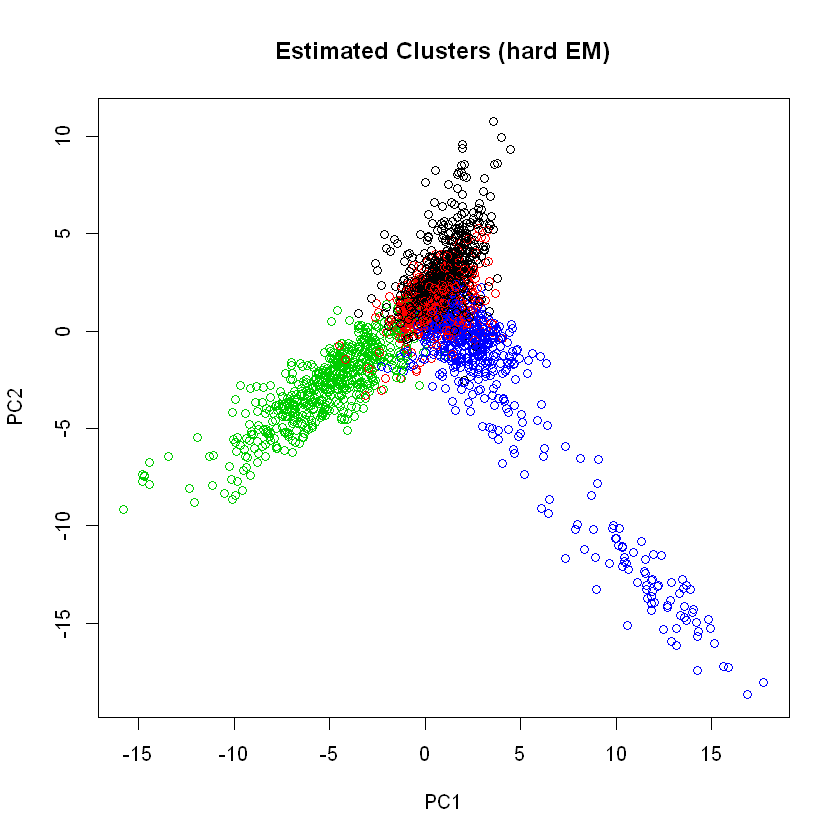

In [126]:
#calling hard EM algorithm on the data

# Reading documents 
## Note: sample.size=0 means all read all documents!
##(for develiopment and debugging use a smaller subset e.g., sample.size = 40)
data <- read.data(file.name='./assessments_datasets/Task3A.txt', sample.size=0, seed=100, pre.proc=TRUE, spr.ratio= .99)

# word-document frequency matrix 
counts <- data$word.doc.mat        
# below is toy data if you want to work with

res.hard<- EM.hard(counts, K=4, max.epoch=5) 

# visualization
## find the culster with the maximum probability (since we have soft assignment here)
label.hat <- apply(res.hard$gamma, 1, which.max) 
## normalize the count matrix for better visualization
counts<-scale(counts) # only use when the dimensionality of the data (number of words) is large enough

## visualize the stimated clusters
cluster.viz(t(counts), label.hat, 'Estimated Clusters (hard EM)')


### Soft EM

In [127]:
EM.soft <- function(counts, K=4, max.epoch=10, seed=123456){
  #INPUTS:
  ## counts: word count matrix
  ## K: the number of clusters
  #OUTPUTS:
  ## model: a list of model parameters
  
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  W <- dim(counts)[1] # number of unique words (in all documents)
  
  # Initialization
  model <- initial.param(W, K=K, seed=seed)
  gamma <- matrix(0, nrow = N, ncol = K)

  print(train_obj(model,counts))
  # Build the model
  for(epoch in 1:max.epoch){
    
    # E Step
    gamma <- E.step(gamma, model, counts)
    # M Step
    model <- M.step(gamma, model, counts)
   
    print(train_obj(model,counts)) 
  }
  # Return Model
  return(list("model"=model,"gamma"=gamma))
}

[1] 2180123
[1] 1949798
[1] 1925915
[1] 1917091
[1] 1915004
[1] 1914274


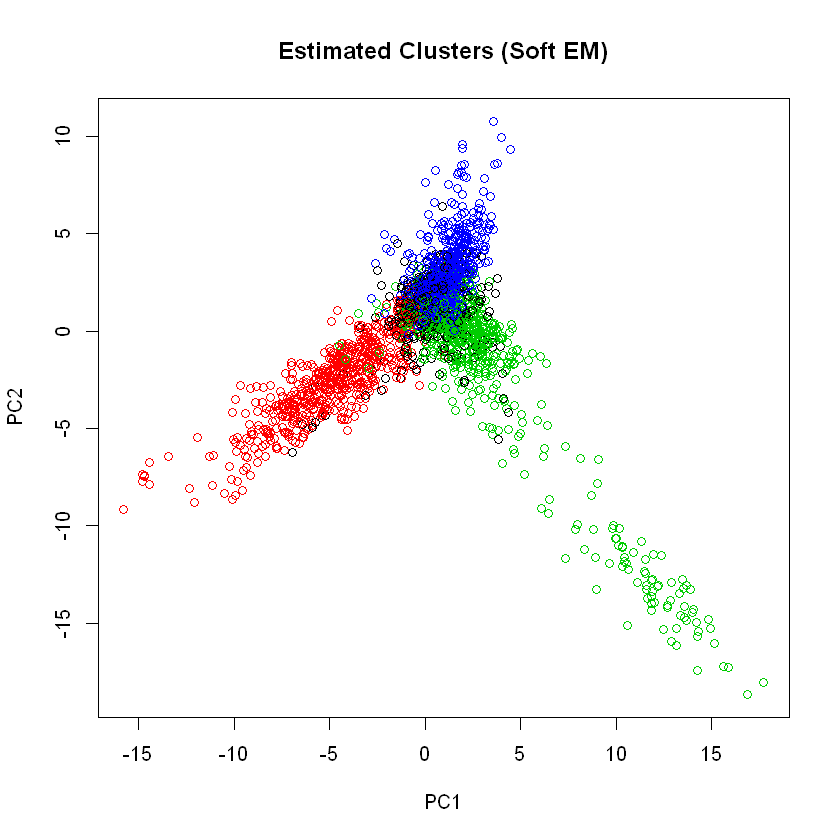

In [128]:
# calling the soft EM algorithm on the data

# Reading documents 
## Note: sample.size=0 means all read all documents!
##(for develiopment and debugging use a smaller subset e.g., sample.size = 40)
data <- read.data(file.name='./assessments_datasets/Task3A.txt', sample.size=0, seed=100, pre.proc=TRUE, spr.ratio= .99)

# word-document frequency matrix 
counts <- data$word.doc.mat        
# below is toy data if you want to work with
# counts <- matrix(c(1,1,0,1,0,0,0,1,1,1,0,1,0,0,1,1,0,0),nrow=3,ncol=6)
res <- EM.soft(counts, K=4, max.epoch=5)   

# visualization
## find the culster with the maximum probability (since we have soft assignment here)
label.hat <- apply(res$gamma, 1, which.max) 
## normalize the count matrix for better visualization
counts<-scale(counts) # only use when the dimensionality of the data (number of words) is large enough

## visualize the stimated clusters
cluster.viz(t(counts), label.hat, 'Estimated Clusters (Soft EM)')


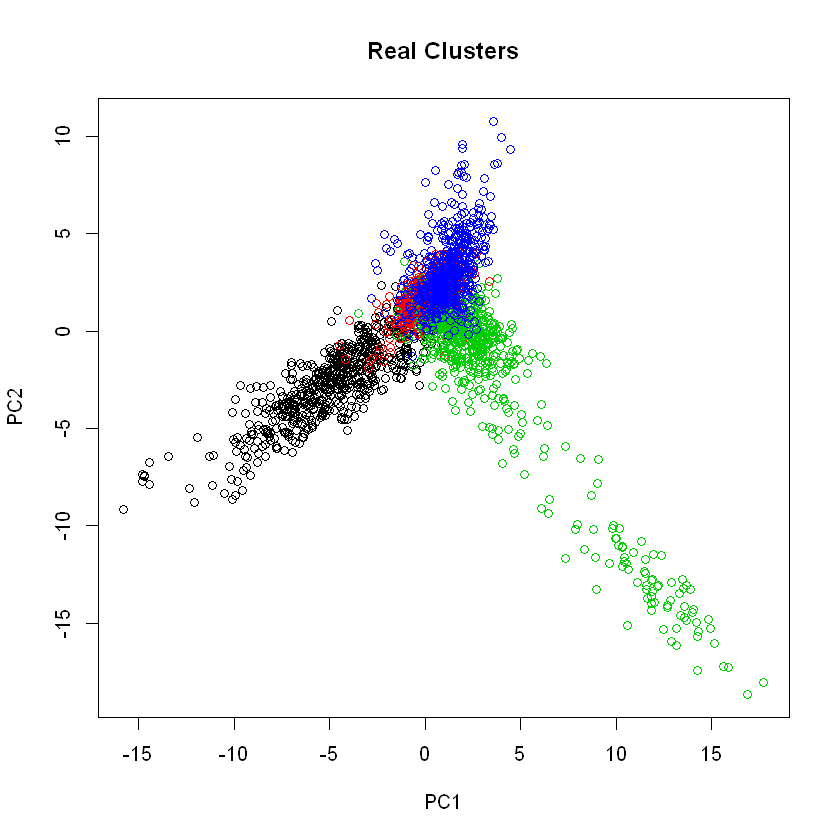

In [129]:
## visualize the real clusters
cluster.viz(t(counts), factor(data$label), 'Real Clusters')